In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os

%matplotlib notebook
#%matplotlib inline

from ipywidgets import interact #, interactive, fixed, interact_manual
import ipywidgets as widgets

def rename_string_to_label(string):
    return(string.replace('b-pulseAlongX_0.22','UV').replace('z-from_S1_without_pulse','FC_1').replace('m-only_IR_longer_with_nac_2_1','IR_long').replace('_0000',''))

# READING DATA

In [2]:
fol = '/home/alessio/k-nokick/'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir not in ['HTML','csv']])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> IMPORTANTS
1 -> b-pulseAlongX_0.22_goodG_0000
2 -> b-pulseAlongX_0.22_short_0_goodG_0000
3 -> b-pulseAlongX_0.22_short_pi_goodG_0000
4 -> h-IR-X_80_0000
5 -> i-IR-Z_80_0000
6 -> k-IR-Y_80_0000
7 -> l-IR-XZ-50_0000
8 -> l-IR-XZ-70_0000
9 -> l-IR-XZ-90_0000
10 -> m-only_IR_longer_with_nac_2_1_0000
11 -> m-only_IR_longer_with_nac_2_1_counterClock_0000
12 -> m-only_IR_longer_with_nac_2_1_inverted_phase_0000
13 -> m-only_IR_longer_with_nac_2_1_phase_pi_0000
14 -> m-only_IR_middle100_0000
15 -> m-only_IR_middle140_0000
16 -> m-only_IR_middle50_0000
17 -> m-only_IR_middle80_0000
18 -> m-only_IR_middle90_0000
19 -> m-only_IR_retarded75_0000
20 -> m-only_IR_retarded80_0000
21 -> m-only_IR_retarded85_0000
22 -> m-only_IR_retarded90_0000
23 -> m-only_IR_short_with_nac_2_1_0000
24 -> m-only_IR_short_with_nac_2_1_inverted_phase_0000
25 -> m-only_IR_short_with_nac_2_1_phase_pi_0000
26 -> n-IR-YZ-50_0000
27 -> n-IR-YZ-70_0000
28 -> n-IR-YZ-90_0000
29 -> x-FC-6-NAC100_0000
30 -> z-from_S1_without

In [3]:
def create_df_from_files_given_name(name,fol,fs_end_pulse):
    '''
    This creates the excel file from the 4 files
    '''
    project_folder = os.path.join(fol,name)
    
    output_norm = os.path.join(project_folder, 'output')
    output_popu = os.path.join(project_folder, 'outputPopul')
    output_abso = os.path.join(project_folder, 'Output_Abs')
    output_regi = os.path.join(project_folder, 'Output_Regions')
    
    df_norm2 = pd.read_csv(output_norm, delim_whitespace=True, index_col=0, names=['counter', 'steps', 'fs','Norm deviation','Kinetic','Potential','Total','Total Deviation','Xpulse','Ypulse','Zpulse'])
    df_popu2 = pd.read_csv(output_popu, delim_whitespace=True, names=['fs', 'S0', 'S1','S2','S3','S4','S5','S6','S7'])
    df_abso2 = pd.read_csv(output_abso, delim_whitespace=True, names=['Time AU', 'Abs Tot', 'Abs S0', 'Abs S1','Abs S2','Abs S3','Abs S4','Abs S5','Abs S6','Abs S7'])
    df_regi2 = pd.read_csv(output_regi, delim_whitespace=True, names=['FC','Reactants','Products'])
    

    # I need to cut down to different file size <- this will become obsolete
    dfs = [df_norm2,df_popu2,df_abso2,df_regi2]
    lengths = min([x.shape[0] for x in dfs])
    
    df_norm, df_popu, df_abso, df_regi = [ x.drop(x.index[lengths:]) for x in dfs ]
    
    AU_dt = df_abso['Time AU'].iloc[1]
    
    #fs_end_pulse = 15 # this is where I start to count Fc population retourning in S0 after the pulse.
    fs_array = df_norm2['fs']
    filtering_on_indexes = np.arange(lengths)
    number_line_after_pulse = np.where(fs_array > fs_end_pulse)[0][0]
    
    fs_after_pulse = df_popu['fs'].iloc[number_line_after_pulse]
    s0_after_pulse = df_popu['S0'].iloc[number_line_after_pulse]
    s1_after_pulse = df_popu['S1'].iloc[number_line_after_pulse]
    s2_after_pulse = df_popu['S2'].iloc[number_line_after_pulse]
    s3_after_pulse = df_popu['S3'].iloc[number_line_after_pulse]
    s4_after_pulse = df_popu['S4'].iloc[number_line_after_pulse]
    s5_after_pulse = df_popu['S5'].iloc[number_line_after_pulse]
    s6_after_pulse = df_popu['S6'].iloc[number_line_after_pulse]
    s7_after_pulse = df_popu['S7'].iloc[number_line_after_pulse]
    
    all_after_pulse = np.array([s0_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse,s5_after_pulse,s6_after_pulse,s7_after_pulse])
    
    if number_line_after_pulse != 0:
        value_to_subtract = df_regi['FC'].iloc[number_line_after_pulse-1]
        df_regi['FC after pulse'] = np.where( filtering_on_indexes < number_line_after_pulse, 0, (df_regi['FC']-value_to_subtract))
    else:
        df_regi['FC after pulse'] = df_regi['FC']
        
    df_all = pd.concat([df_norm,df_popu,df_abso,df_regi],axis=1)
    
    csv_name = '{}.csv'.format(project_folder)
    
    print('{} #steps {} - End pulse {} - S1: {:8.5E} - S2: {:8.5E} - S3: {:8.5E} - S4: {:8.5E} {}'.format(AU_dt,lengths, fs_after_pulse,s1_after_pulse,s2_after_pulse,s3_after_pulse,s4_after_pulse,name))
    
    # ok this part needs comment. We want to normalize the S1 population to 1, to make the absorbed product count "fair"
    # But the population in S1 is "moving" due to the other states continuosly absorbing/feeding it
    # We make the assumption that all the other states are a single superstate that "feeds" only S1.
    # So we sum up states from S2 to S7. Then we take the population of those states (2 to 7) after the pulse. We want to 
    # know after the pulse what is the CHANGE in population due to NAC of this "super state".
    # our normalization factor for S1 at time T is ten the 
    
    df_all['sum_others'] = (df_all['S2'] + df_all['S3'] + df_all['S4'] + df_all['S5'] + df_all['S6'] + df_all['S7'])
    df_all['sum_others_minus_after_pulse'] = sum(all_after_pulse[2:]) - df_all['sum_others']
    df_all['Norm_factor (t)'] = all_after_pulse[1] + df_all['sum_others_minus_after_pulse']
    
    df_all['P(t) Tot'] = -(np.cumsum(df_all['Abs Tot'])*AU_dt)
    df_all['P(t) S0'] =  -(np.cumsum(df_all['Abs S0'])*AU_dt)
    df_all['P(t) S1'] =  -(np.cumsum(df_all['Abs S1'])*AU_dt)
    df_all['P(t) S2'] =  -(np.cumsum(df_all['Abs S2'])*AU_dt)
    df_all['P(t) S3'] =  -(np.cumsum(df_all['Abs S3'])*AU_dt)
    df_all['P(t) S4'] =  -(np.cumsum(df_all['Abs S4'])*AU_dt)
    df_all['P(t) S5'] =  -(np.cumsum(df_all['Abs S5'])*AU_dt)
    df_all['P(t) S6'] =  -(np.cumsum(df_all['Abs S6'])*AU_dt)
    df_all['P(t) S7'] =  -(np.cumsum(df_all['Abs S7'])*AU_dt)
    
    df_all['AU_dt'] = AU_dt
    
    df_all['Products_F']  = df_all['Products']  + df_all['P(t) S0']
    #df_all['Reactants_F'] = df_all['Reactants'] + df_all['FC after pulse']
    df_all['Reactants_F'] = df_all['Reactants']
    
#     df_all['Real Reactants'] = df_regi['Reactants'] + df_regi['FC after pulse']
#     df_all['Real Products'] = df_regi['Products'] + df_abso['Norm S0']
#     df_all['Real ratio'] = df_all['Real Products']/df_all['Real Reactants']
    
    df_all.to_csv(csv_name)
    
    #df_all.plot('fs',['Reactants','Products'])
    #df_all.plot('fs','ratio')
    #df_all.plot('fs',['Real Reactants','Real Products'])
    #return(df_all[['fs','Norm_factor (t)','sum_others_minus_after_pulse','sum_others']])
    #return(df_all[['Norm Tot','fs','ratio','Real Products','Real Reactants','Abs S0','Norm S0', 'Products', 'Reactants','Real ratio','S1','S2','S3','S0','S4','S5','S6','S7','Xpulse','Ypulse','Norm_factor (t)','sum_others_minus_after_pulse','sum_others','Norm deviation','Absorbed Normalized','FC after pulse']])
    return(df_all)
    
number = 3

a = create_df_from_files_given_name('z-from_S1_without_pulse_0000',fol,0)
b = create_df_from_files_given_name('b-pulseAlongX_0.22_goodG_0000',fol,15)
c = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_0000',fol,15)
d = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_counterClock_0000',fol,15)
e = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_inverted_phase_0000',fol,15)
f = create_df_from_files_given_name('m-only_IR_longer_with_nac_2_1_phase_pi_0000',fol,15)
g = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_0000',fol,15)
h = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_inverted_phase_0000',fol,15)
i = create_df_from_files_given_name('m-only_IR_short_with_nac_2_1_phase_pi_0000',fol,15)
l = create_df_from_files_given_name('b-pulseAlongX_0.22_short_0_goodG_0000',fol,15)
m = create_df_from_files_given_name('b-pulseAlongX_0.22_short_pi_goodG_0000',fol,15)
# z2 = create_df_from_files_given_name('z-from_S2_without_pulse_0000',fol,0)   # <- need to do regions and abs file

qp.warning('Watch out you are putting the time (fs) of END_pulse MANUALLY')

4.1341 #steps 2001 - End pulse 0.1001 - S1: 9.99999E-01 - S2: 5.04933E-08 - S3: 2.78770E-09 - S4: 8.25528E-07 z-from_S1_without_pulse_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 5.23371E-01 - S2: 4.28769E-03 - S3: 4.60010E-03 - S4: 2.39223E-02 b-pulseAlongX_0.22_goodG_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 7.48783E-02 - S2: 1.42336E-01 - S3: 1.53815E-01 - S4: 7.16697E-03 m-only_IR_longer_with_nac_2_1_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 7.24644E-02 - S2: 1.50438E-01 - S3: 1.48564E-01 - S4: 6.84737E-03 m-only_IR_longer_with_nac_2_1_counterClock_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 9.13654E-02 - S2: 1.71509E-01 - S3: 1.17080E-01 - S4: 8.25344E-03 m-only_IR_longer_with_nac_2_1_inverted_phase_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 7.67448E-02 - S2: 1.43184E-01 - S3: 1.54398E-01 - S4: 6.98713E-03 m-only_IR_longer_with_nac_2_1_phase_pi_0000
2.0671 #steps 4001 - End pulse 15.015 - S1: 2.78913E-02 - S2: 8.07435E-02 - S3: 7.84192E-02 - S4: 1.9935

In [4]:
colors = ['b', 'g', 'r', 'm', 'c', 'y', 'k', 'mediumpurple']

# UV vs FC

<IPython.core.display.Javascript object>


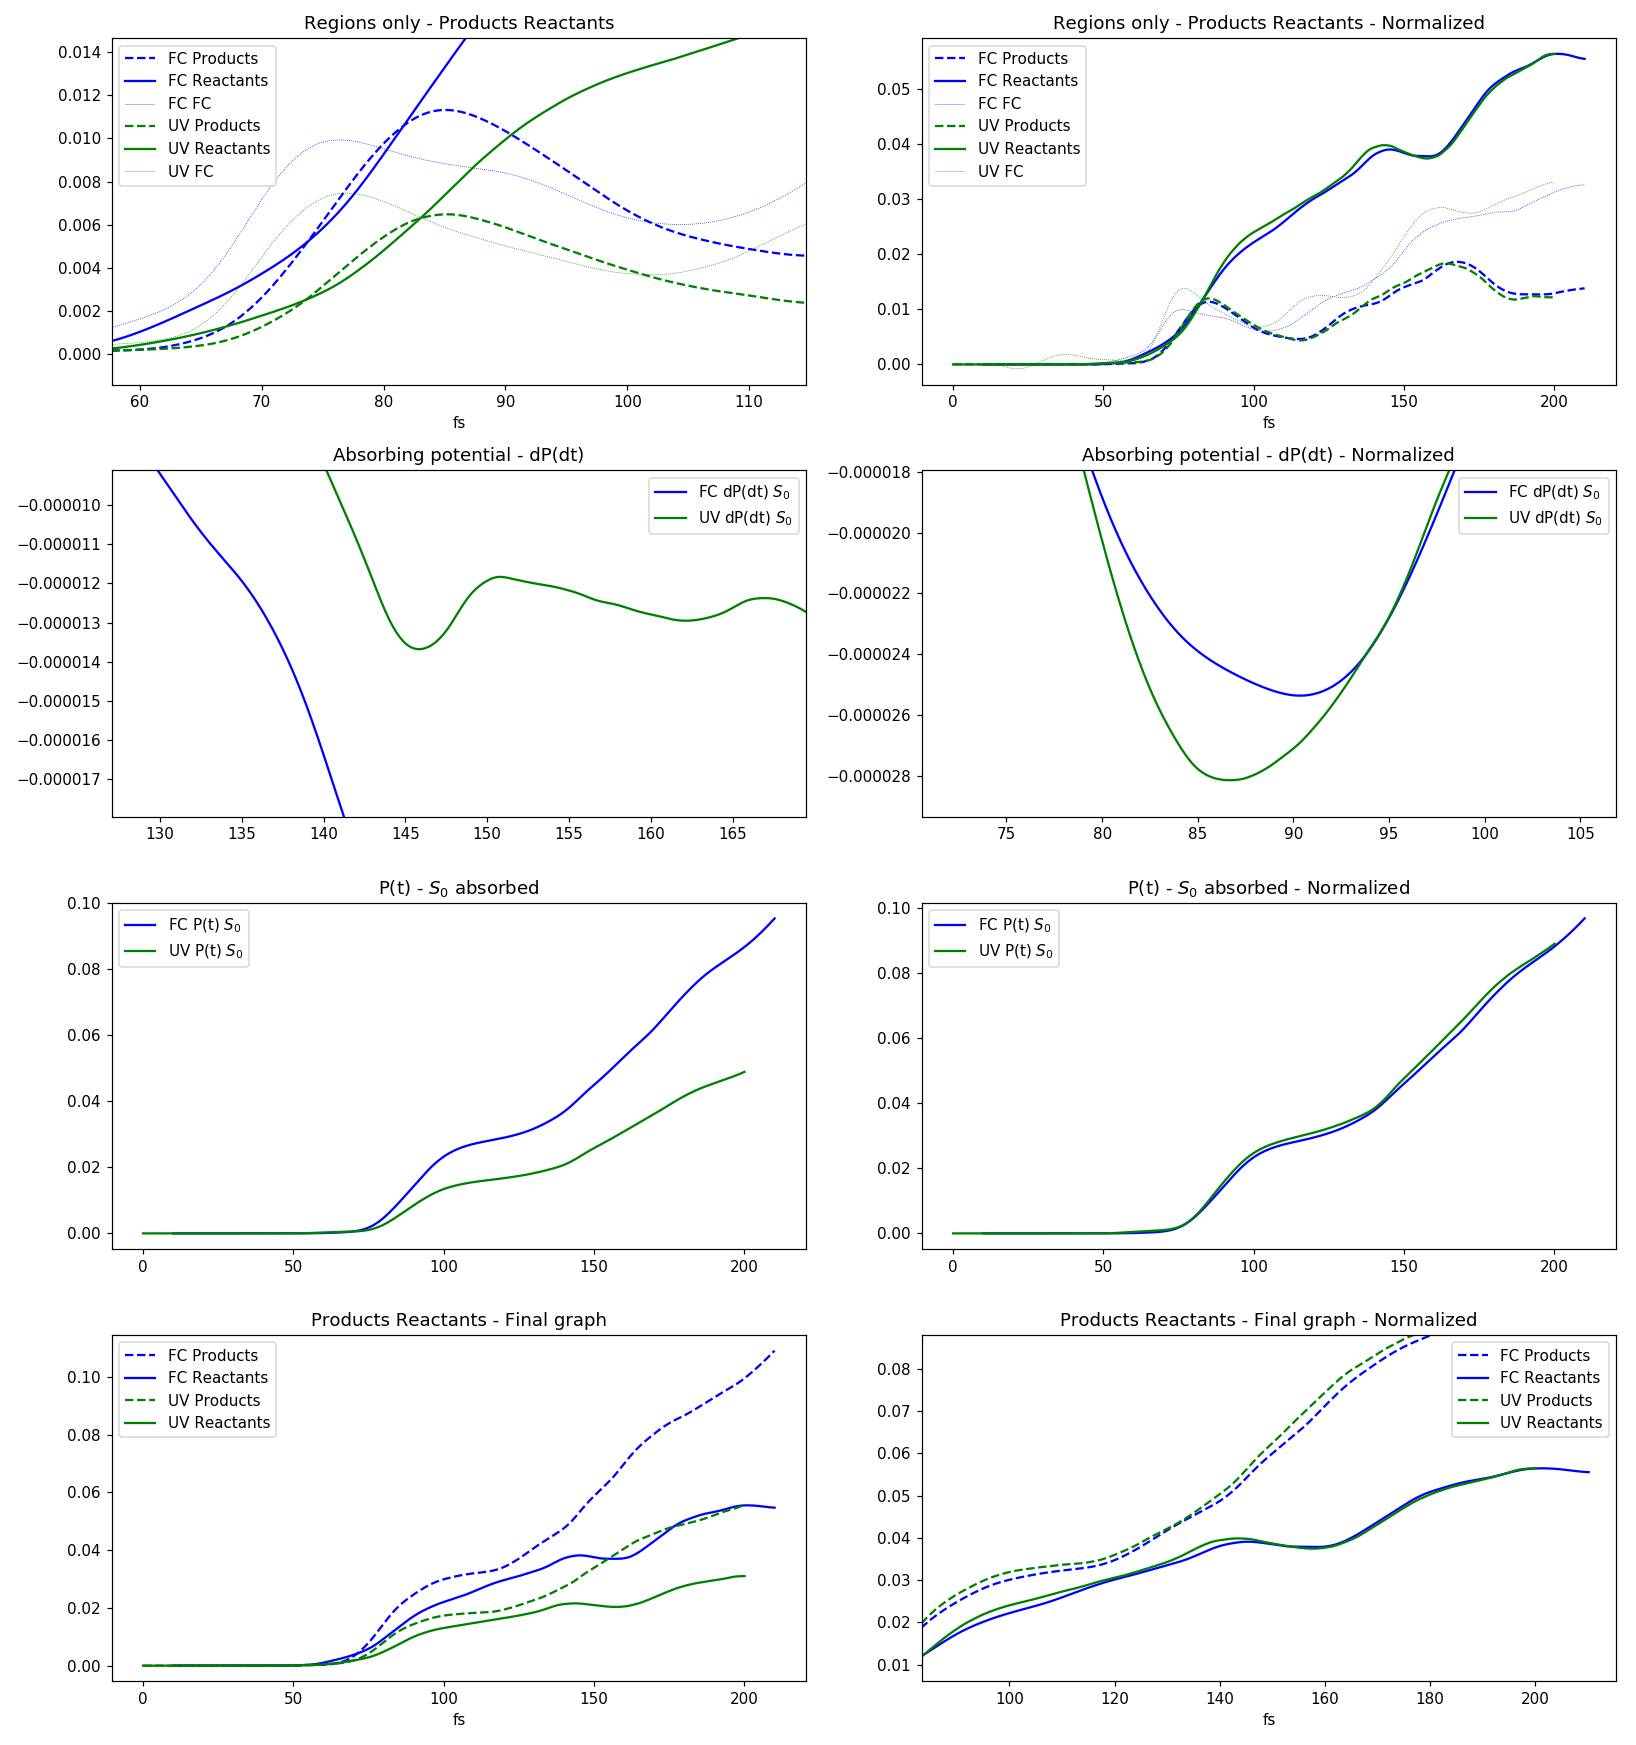

In [5]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

ax0.plot(a['fs'].iloc[:,1]+10,  a['Products'] , label='FC Products',  ls='--', color=colors[0])
ax0.plot(a['fs'].iloc[:,1]+10,  a['Reactants'], label='FC Reactants', color=colors[0])
ax0.plot(a['fs'].iloc[:,1]+10,  a['FC after pulse'],   label='FC FC', ls=':', lw=0.5, color=colors[0])

ax0.plot(b['fs'].iloc[:,1],     b['Products'] , label='UV Products',  ls='--', color=colors[1])
ax0.plot(b['fs'].iloc[:,1],     b['Reactants'], label='UV Reactants', color=colors[1])
ax0.plot(b['fs'].iloc[:,1],     b['FC after pulse'], label='UV FC', ls=':', lw=0.5, color=colors[1])
ax0.set_xlabel('fs')
ax0.set_title('Regions only - Products Reactants')
ax0.legend()

ax2.plot(a['fs'].iloc[:,1]+10,  a['Abs S0'], label=r'FC dP(dt) $S_0$', color=colors[0])
ax2.plot(b['fs'].iloc[:,1],     b['Abs S0'], label=r'UV dP(dt) $S_0$', color=colors[1])
ax2.set_title('Absorbing potential - dP(dt)')
ax2.legend()

ax4.plot(a['fs'].iloc[:,1]+10,  a['P(t) S0'],   label=r'FC P(t) $S_0$', color=colors[0])
ax4.plot(b['fs'].iloc[:,1],     b['P(t) S0'],   label=r'UV P(t) $S_0$', color=colors[1])
ax4.set_title(r'P(t) - $S_0$ absorbed')
ax4.legend()

ax6.plot(a['fs'].iloc[:,1]+10,  a['Products_F'] , label='FC Products',  ls='--', color=colors[0])
ax6.plot(a['fs'].iloc[:,1]+10,  a['Reactants_F'],   label='FC Reactants', color=colors[0])
ax6.plot(b['fs'].iloc[:,1],     b['Products_F'] , label='UV Products',  ls='--', color=colors[1])
ax6.plot(b['fs'].iloc[:,1],     b['Reactants_F'],   label='UV Reactants', color=colors[1])
ax6.set_xlabel('fs')
ax6.set_title('Products Reactants - Final graph')
ax6.legend()

# right part, normalized ones

ax1.plot(a['fs'].iloc[:,1]+10,  a['Products']/a['Norm_factor (t)'], label='FC Products',  ls='--', color=colors[0])
ax1.plot(a['fs'].iloc[:,1]+10,  a['Reactants']/a['Norm_factor (t)'], label='FC Reactants', color=colors[0])
ax1.plot(a['fs'].iloc[:,1]+10,  a['FC after pulse']/a['Norm_factor (t)'],   label='FC FC', ls=':', lw=0.5, color=colors[0])

ax1.plot(b['fs'].iloc[:,1],     b['Products']/b['Norm_factor (t)'], label='UV Products',  ls='--', color=colors[1])
ax1.plot(b['fs'].iloc[:,1],     b['Reactants']/b['Norm_factor (t)'], label='UV Reactants', color=colors[1])
ax1.plot(b['fs'].iloc[:,1],     b['FC after pulse']/b['Norm_factor (t)'], label='UV FC', ls=':', lw=0.5, color=colors[1])

ax1.set_xlabel('fs')
ax1.set_title('Regions only - Products Reactants - Normalized')
ax1.legend()

ax3.plot(a['fs'].iloc[:,1]+10,  a['Abs S0']/a['Norm_factor (t)'], label=r'FC dP(dt) $S_0$', color=colors[0])
ax3.plot(b['fs'].iloc[:,1],     b['Abs S0']/b['Norm_factor (t)'], label=r'UV dP(dt) $S_0$', color=colors[1])
ax3.set_title('Absorbing potential - dP(dt) - Normalized')
ax3.legend()

ax5.plot(a['fs'].iloc[:,1]+10,  a['P(t) S0']/a['Norm_factor (t)'],   label=r'FC P(t) $S_0$', color=colors[0])
ax5.plot(b['fs'].iloc[:,1],     b['P(t) S0']/b['Norm_factor (t)'],   label=r'UV P(t) $S_0$', color=colors[1])
ax5.set_title(r'P(t) - $S_0$ absorbed - Normalized')
ax5.legend()

ax7.plot(a['fs'].iloc[:,1]+10,  a['Products_F']/a['Norm_factor (t)'], label='FC Products',  ls='--', color=colors[0])
ax7.plot(a['fs'].iloc[:,1]+10,  a['Reactants_F']/a['Norm_factor (t)'],   label='FC Reactants', color=colors[0])
ax7.plot(b['fs'].iloc[:,1],     b['Products_F']/b['Norm_factor (t)'], label='UV Products',  ls='--', color=colors[1])
ax7.plot(b['fs'].iloc[:,1],     b['Reactants_F']/b['Norm_factor (t)'],   label='UV Reactants', color=colors[1])
ax7.set_xlabel('fs')
ax7.set_title('Products Reactants - Final graph - Normalized')
ax7.legend()

fig.tight_layout();

<IPython.core.display.Javascript object>


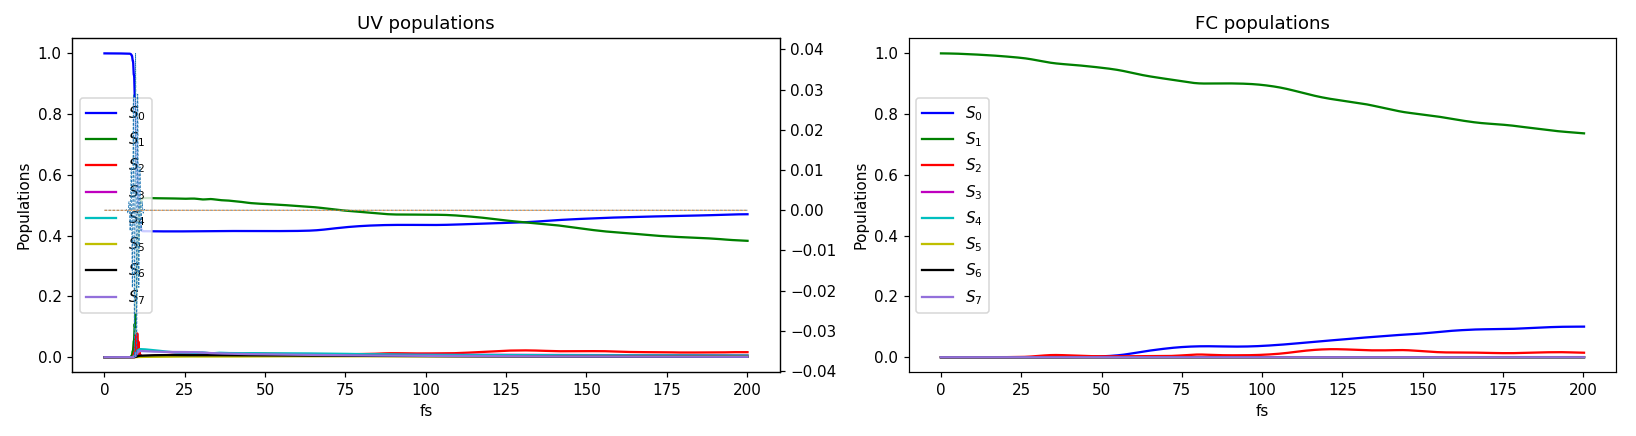

In [122]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(15,4))

ax0.plot(b['fs'].iloc[:,1], b['S0'], label=r'$S_0$', color=colors[0])
ax0.plot(b['fs'].iloc[:,1], b['S1'], label=r'$S_1$', color=colors[1])
ax0.plot(b['fs'].iloc[:,1], b['S2'], label=r'$S_2$', color=colors[2])
ax0.plot(b['fs'].iloc[:,1], b['S3'], label=r'$S_3$', color=colors[3])
ax0.plot(b['fs'].iloc[:,1], b['S4'], label=r'$S_4$', color=colors[4])
ax0.plot(b['fs'].iloc[:,1], b['S5'], label=r'$S_5$', color=colors[5])
ax0.plot(b['fs'].iloc[:,1], b['S6'], label=r'$S_6$', color=colors[6])
ax0.plot(b['fs'].iloc[:,1], b['S7'], label=r'$S_7$', color=colors[7])
ax00 = ax0.twinx()
ax00.plot(b['fs'].iloc[:,1], b['Xpulse'], label='X_pulse', ls='--', lw=.5)
#ax00.plot(b['fs'].iloc[:,1], b['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax0.set_title('UV populations')
ax0.set_ylabel('Populations')
ax0.set_xlabel('fs')
ax0.legend()

ax1.plot(a['fs'].iloc[:,1], a['S0'], label=r'$S_0$', color=colors[0])
ax1.plot(a['fs'].iloc[:,1], a['S1'], label=r'$S_1$', color=colors[1])
ax1.plot(a['fs'].iloc[:,1], a['S2'], label=r'$S_2$', color=colors[2])
ax1.plot(a['fs'].iloc[:,1], a['S3'], label=r'$S_3$', color=colors[3])
ax1.plot(a['fs'].iloc[:,1], a['S4'], label=r'$S_4$', color=colors[4])
ax1.plot(a['fs'].iloc[:,1], a['S5'], label=r'$S_5$', color=colors[5])
ax1.plot(a['fs'].iloc[:,1], a['S6'], label=r'$S_6$', color=colors[6])
ax1.plot(a['fs'].iloc[:,1], a['S7'], label=r'$S_7$', color=colors[7])
ax1.set_title('FC populations')
ax1.set_ylabel('Populations')
ax1.set_xlabel('fs')
ax1.legend()

fig.tight_layout();

# IR ones

<IPython.core.display.Javascript object>


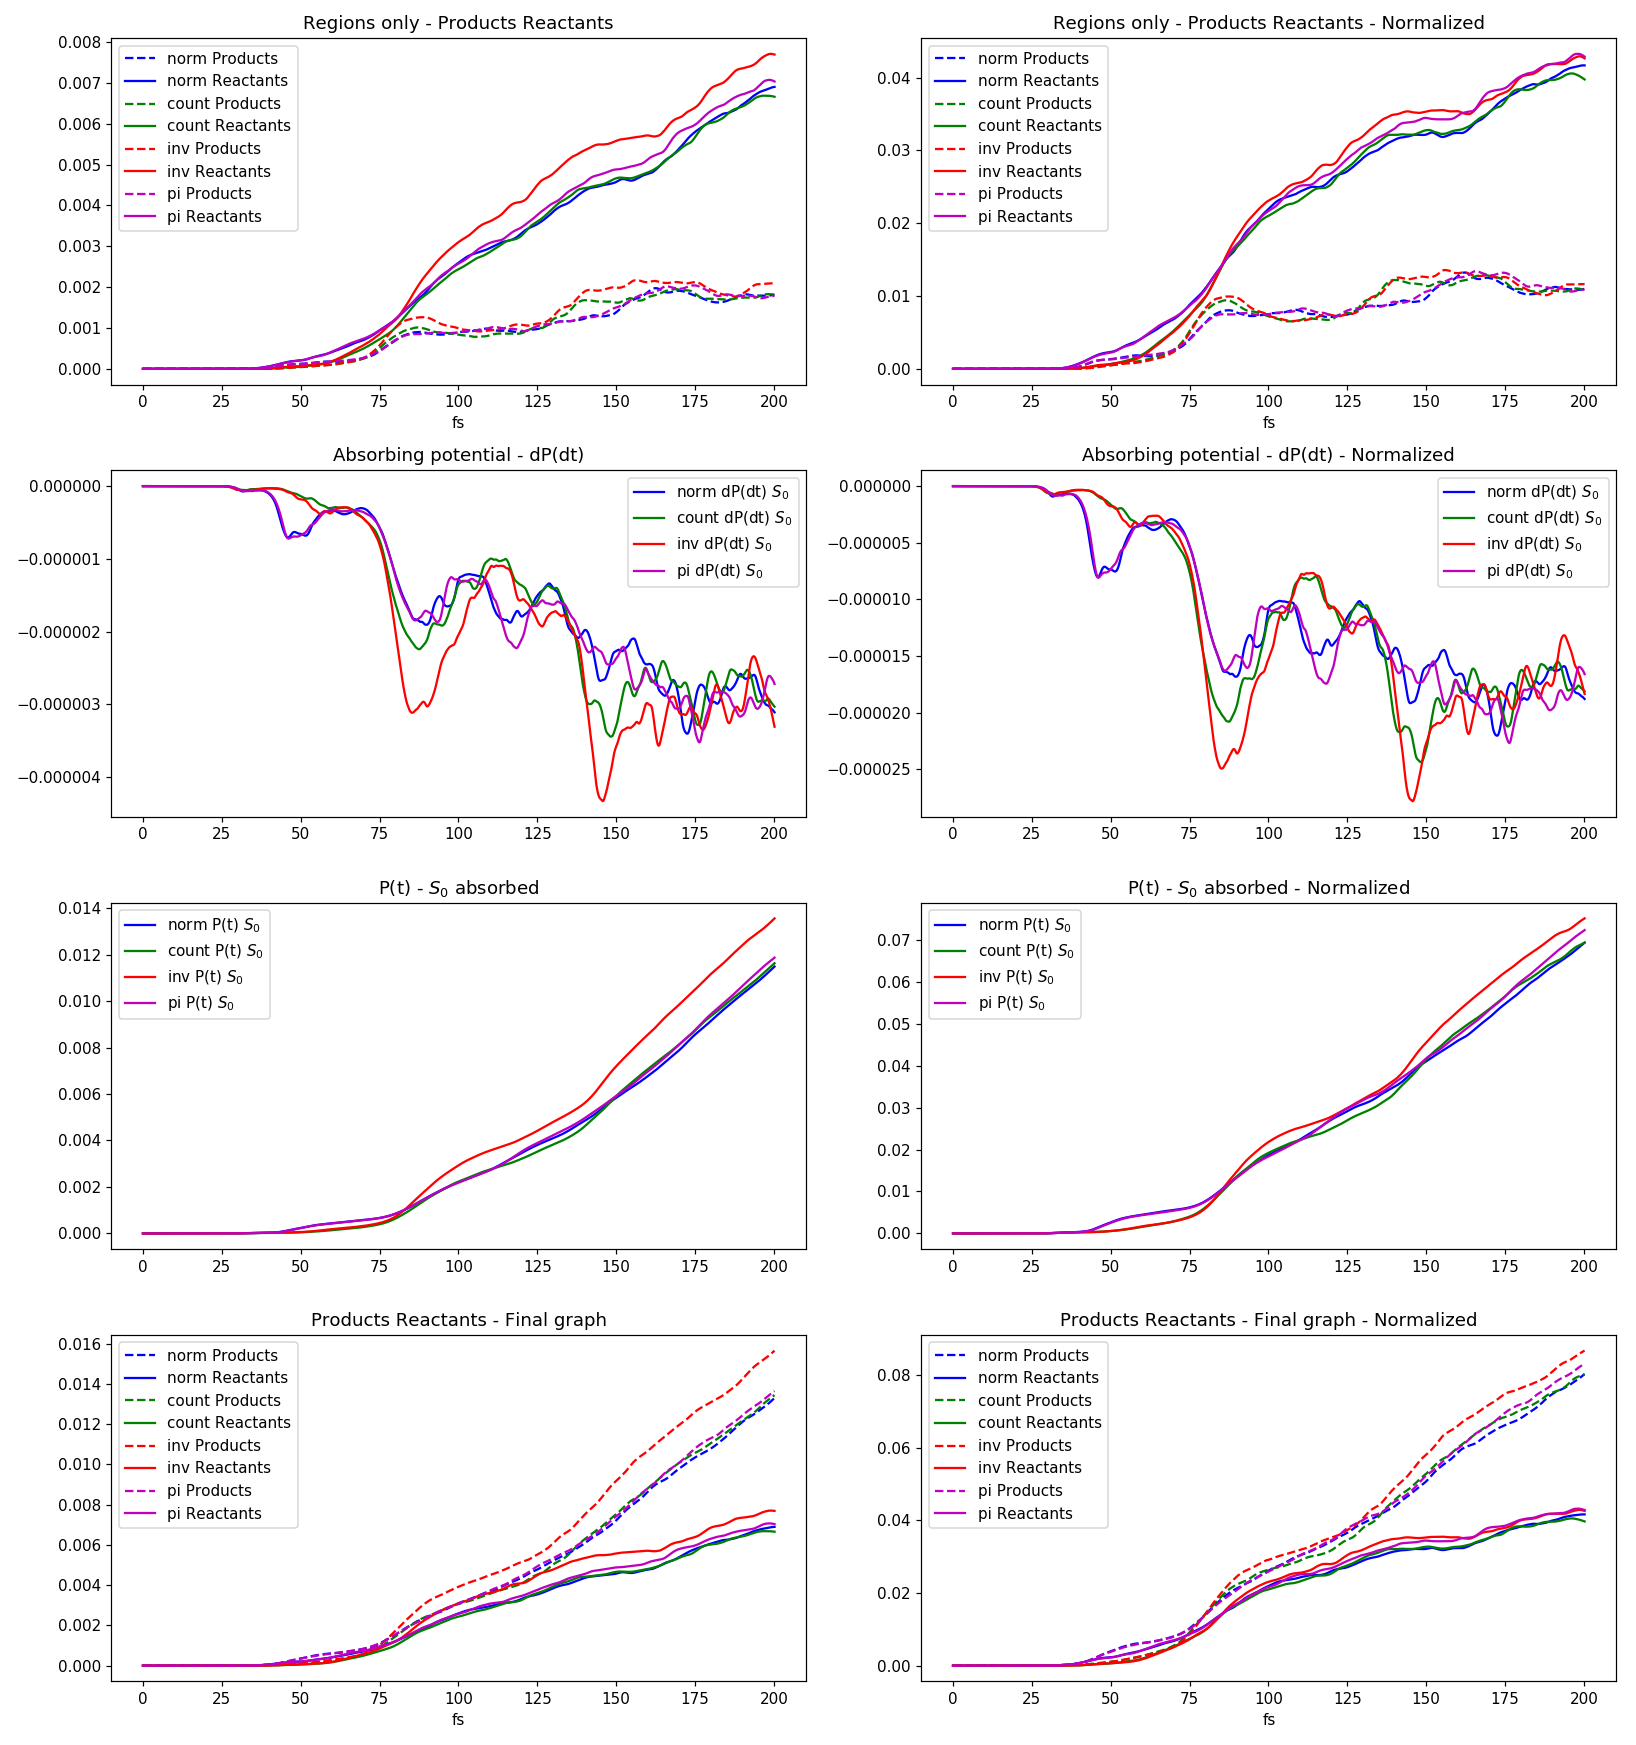

In [24]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

labelz = ['norm','count','inv','pi']
runs = [c,d,e,f]

for ind,i in enumerate(runs):
    ax0.plot(i['fs'].iloc[:,1],  i['Products']    , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax0.plot(i['fs'].iloc[:,1],  i['Reactants']   , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax0.plot(i['fs'].iloc[:,1],  i['FC after pulse'], label='{} FC'.format(labelz[ind])       , ls=':', lw=0.5,  color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Products'] /i['Norm_factor (t)']    , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Reactants']/i['Norm_factor (t)']    , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax1.plot(i['fs'].iloc[:,1],  i['FC after pulse']/i['Norm_factor (t)'], label='{} FC'.format(labelz[ind])       , ls=':', lw=0.5,  color=colors[ind])

ax0.set_xlabel('fs')
ax0.set_title('Regions only - Products Reactants')
ax0.legend()
ax1.set_xlabel('fs')
ax1.set_title('Regions only - Products Reactants - Normalized')
ax1.legend()

for ind,i in enumerate(runs):
    ax2.plot(i['fs'].iloc[:,1],     i['Abs S0'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax3.plot(i['fs'].iloc[:,1],     i['Abs S0']/i['Norm_factor (t)'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])

ax2.set_title('Absorbing potential - dP(dt)')
ax2.legend()
ax3.set_title('Absorbing potential - dP(dt) - Normalized')
ax3.legend()


for ind,i in enumerate(runs):
    ax4.plot(i['fs'].iloc[:,1],     i['P(t) S0'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax5.plot(i['fs'].iloc[:,1],     i['P(t) S0']/i['Norm_factor (t)'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    
ax4.set_title(r'P(t) - $S_0$ absorbed')
ax4.legend()
ax5.set_title(r'P(t) - $S_0$ absorbed - Normalized')
ax5.legend()

for ind,i in enumerate(runs):
    ax6.plot(i['fs'].iloc[:,1],     i['Products_F'] ,   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax6.plot(i['fs'].iloc[:,1],     i['Reactants_F'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Products_F'] /i['Norm_factor (t)'],   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Reactants_F']/i['Norm_factor (t)'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])

ax6.set_xlabel('fs')
ax6.set_title('Products Reactants - Final graph')
ax6.legend()
ax7.set_xlabel('fs')
ax7.set_title('Products Reactants - Final graph - Normalized')
ax7.legend()


fig.tight_layout();

<IPython.core.display.Javascript object>


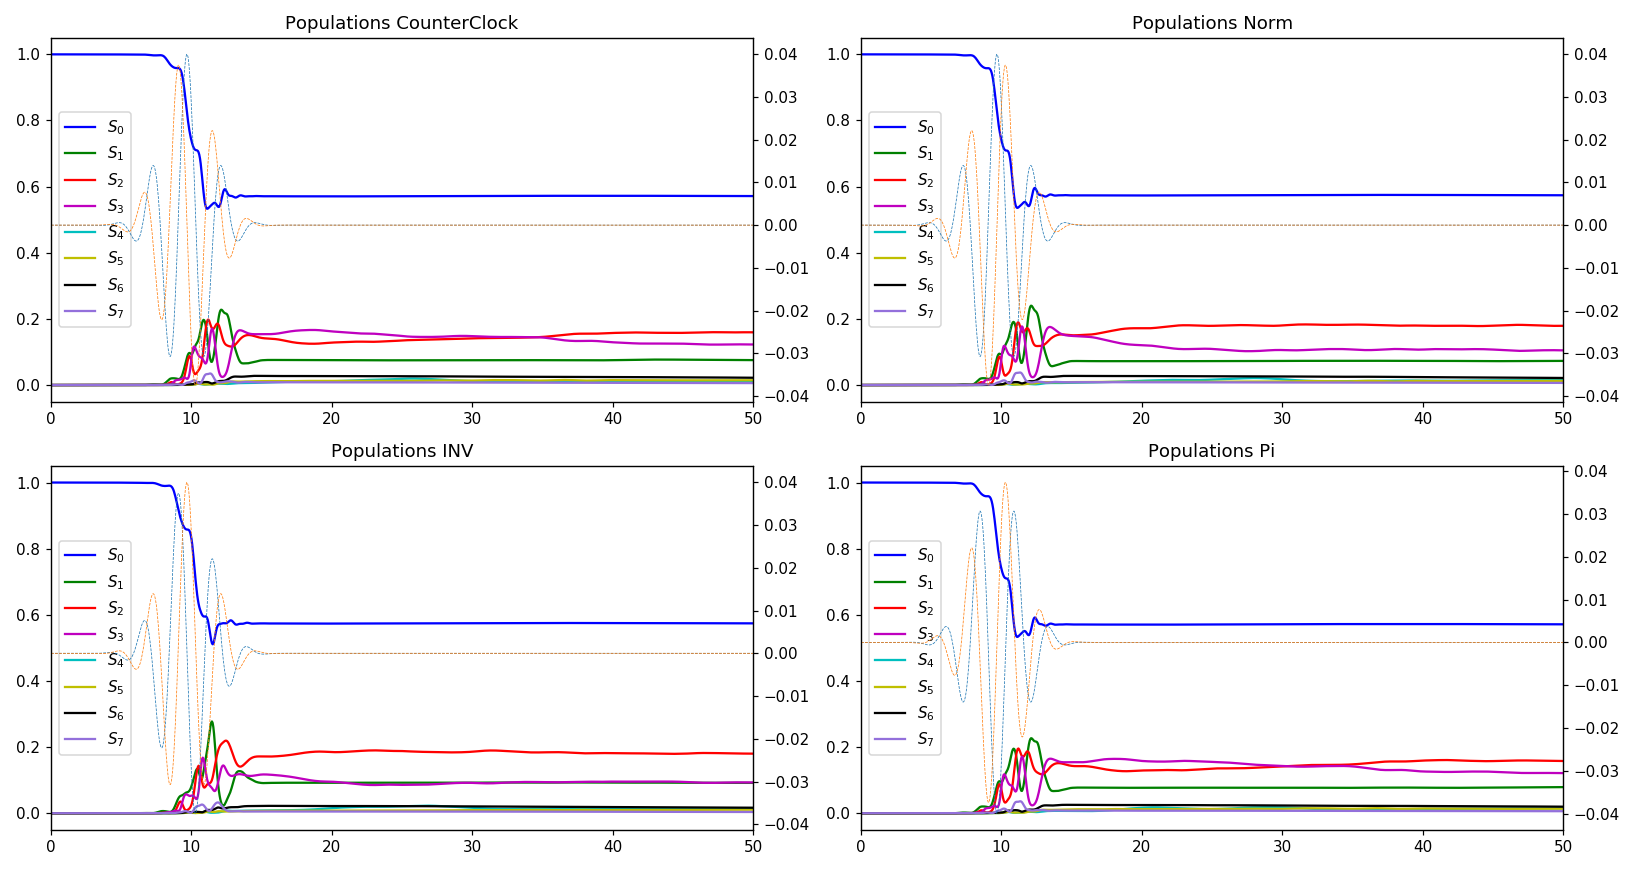

In [26]:
fig, [[ax5,ax6],[ax4,ax7]] = plt.subplots(2,2,figsize=(15,8))

ax5.plot(c['fs'].iloc[:,1], c['S0'], label=r'$S_0$', color=colors[0])
ax5.plot(c['fs'].iloc[:,1], c['S1'], label=r'$S_1$', color=colors[1])
ax5.plot(c['fs'].iloc[:,1], c['S2'], label=r'$S_2$', color=colors[2])
ax5.plot(c['fs'].iloc[:,1], c['S3'], label=r'$S_3$', color=colors[3])
ax5.plot(c['fs'].iloc[:,1], c['S4'], label=r'$S_4$', color=colors[4])
ax5.plot(c['fs'].iloc[:,1], c['S5'], label=r'$S_5$', color=colors[5])
ax5.plot(c['fs'].iloc[:,1], c['S6'], label=r'$S_6$', color=colors[6])
ax5.plot(c['fs'].iloc[:,1], c['S7'], label=r'$S_7$', color=colors[7])

ax55 = ax5.twinx()
ax55.plot(c['fs'].iloc[:,1], c['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax55.plot(c['fs'].iloc[:,1], c['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax5.set_title('Populations CounterClock')
ax5.set_xlim(0,50)
ax5.legend()

ax6.plot(d['fs'].iloc[:,1], d['S0'], label=r'$S_0$', color=colors[0])
ax6.plot(d['fs'].iloc[:,1], d['S1'], label=r'$S_1$', color=colors[1])
ax6.plot(d['fs'].iloc[:,1], d['S2'], label=r'$S_2$', color=colors[2])
ax6.plot(d['fs'].iloc[:,1], d['S3'], label=r'$S_3$', color=colors[3])
ax6.plot(d['fs'].iloc[:,1], d['S4'], label=r'$S_4$', color=colors[4])
ax6.plot(d['fs'].iloc[:,1], d['S5'], label=r'$S_5$', color=colors[5])
ax6.plot(d['fs'].iloc[:,1], d['S6'], label=r'$S_6$', color=colors[6])
ax6.plot(d['fs'].iloc[:,1], d['S7'], label=r'$S_7$', color=colors[7])

ax66 = ax6.twinx()
ax66.plot(d['fs'].iloc[:,1], d['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax66.plot(d['fs'].iloc[:,1], d['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax6.set_title('Populations Norm')
#ax5.set_ylim(0,0.3)
ax6.set_xlim(0,50)
ax6.legend()

ax4.plot(e['fs'].iloc[:,1], e['S0'], label=r'$S_0$', color=colors[0])
ax4.plot(e['fs'].iloc[:,1], e['S1'], label=r'$S_1$', color=colors[1])
ax4.plot(e['fs'].iloc[:,1], e['S2'], label=r'$S_2$', color=colors[2])
ax4.plot(e['fs'].iloc[:,1], e['S3'], label=r'$S_3$', color=colors[3])
ax4.plot(e['fs'].iloc[:,1], e['S4'], label=r'$S_4$', color=colors[4])
ax4.plot(e['fs'].iloc[:,1], e['S5'], label=r'$S_5$', color=colors[5])
ax4.plot(e['fs'].iloc[:,1], e['S6'], label=r'$S_6$', color=colors[6])
ax4.plot(e['fs'].iloc[:,1], e['S7'], label=r'$S_7$', color=colors[7])

ax44 = ax4.twinx()
ax44.plot(e['fs'].iloc[:,1], e['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax44.plot(e['fs'].iloc[:,1], e['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax4.set_title('Populations INV')
#ax4.set_ylim(0,0.3)
ax4.set_xlim(0,50)
ax4.legend()

ax7.plot(f['fs'].iloc[:,1], f['S0'], label=r'$S_0$', color=colors[0])
ax7.plot(f['fs'].iloc[:,1], f['S1'], label=r'$S_1$', color=colors[1])
ax7.plot(f['fs'].iloc[:,1], f['S2'], label=r'$S_2$', color=colors[2])
ax7.plot(f['fs'].iloc[:,1], f['S3'], label=r'$S_3$', color=colors[3])
ax7.plot(f['fs'].iloc[:,1], f['S4'], label=r'$S_4$', color=colors[4])
ax7.plot(f['fs'].iloc[:,1], f['S5'], label=r'$S_5$', color=colors[5])
ax7.plot(f['fs'].iloc[:,1], f['S6'], label=r'$S_6$', color=colors[6])
ax7.plot(f['fs'].iloc[:,1], f['S7'], label=r'$S_7$', color=colors[7])

ax77 = ax7.twinx()
ax77.plot(f['fs'].iloc[:,1], f['Xpulse'], label='X_pulse', ls='--', lw=.5)
ax77.plot(f['fs'].iloc[:,1], f['Ypulse'], label='Y_pulse', ls='--', lw=.5)
ax7.set_title('Populations Pi')
#ax5.set_ylim(0,0.3)
ax7.set_xlim(0,50)
ax7.legend()

fig.tight_layout();

# IR vs UV

<IPython.core.display.Javascript object>


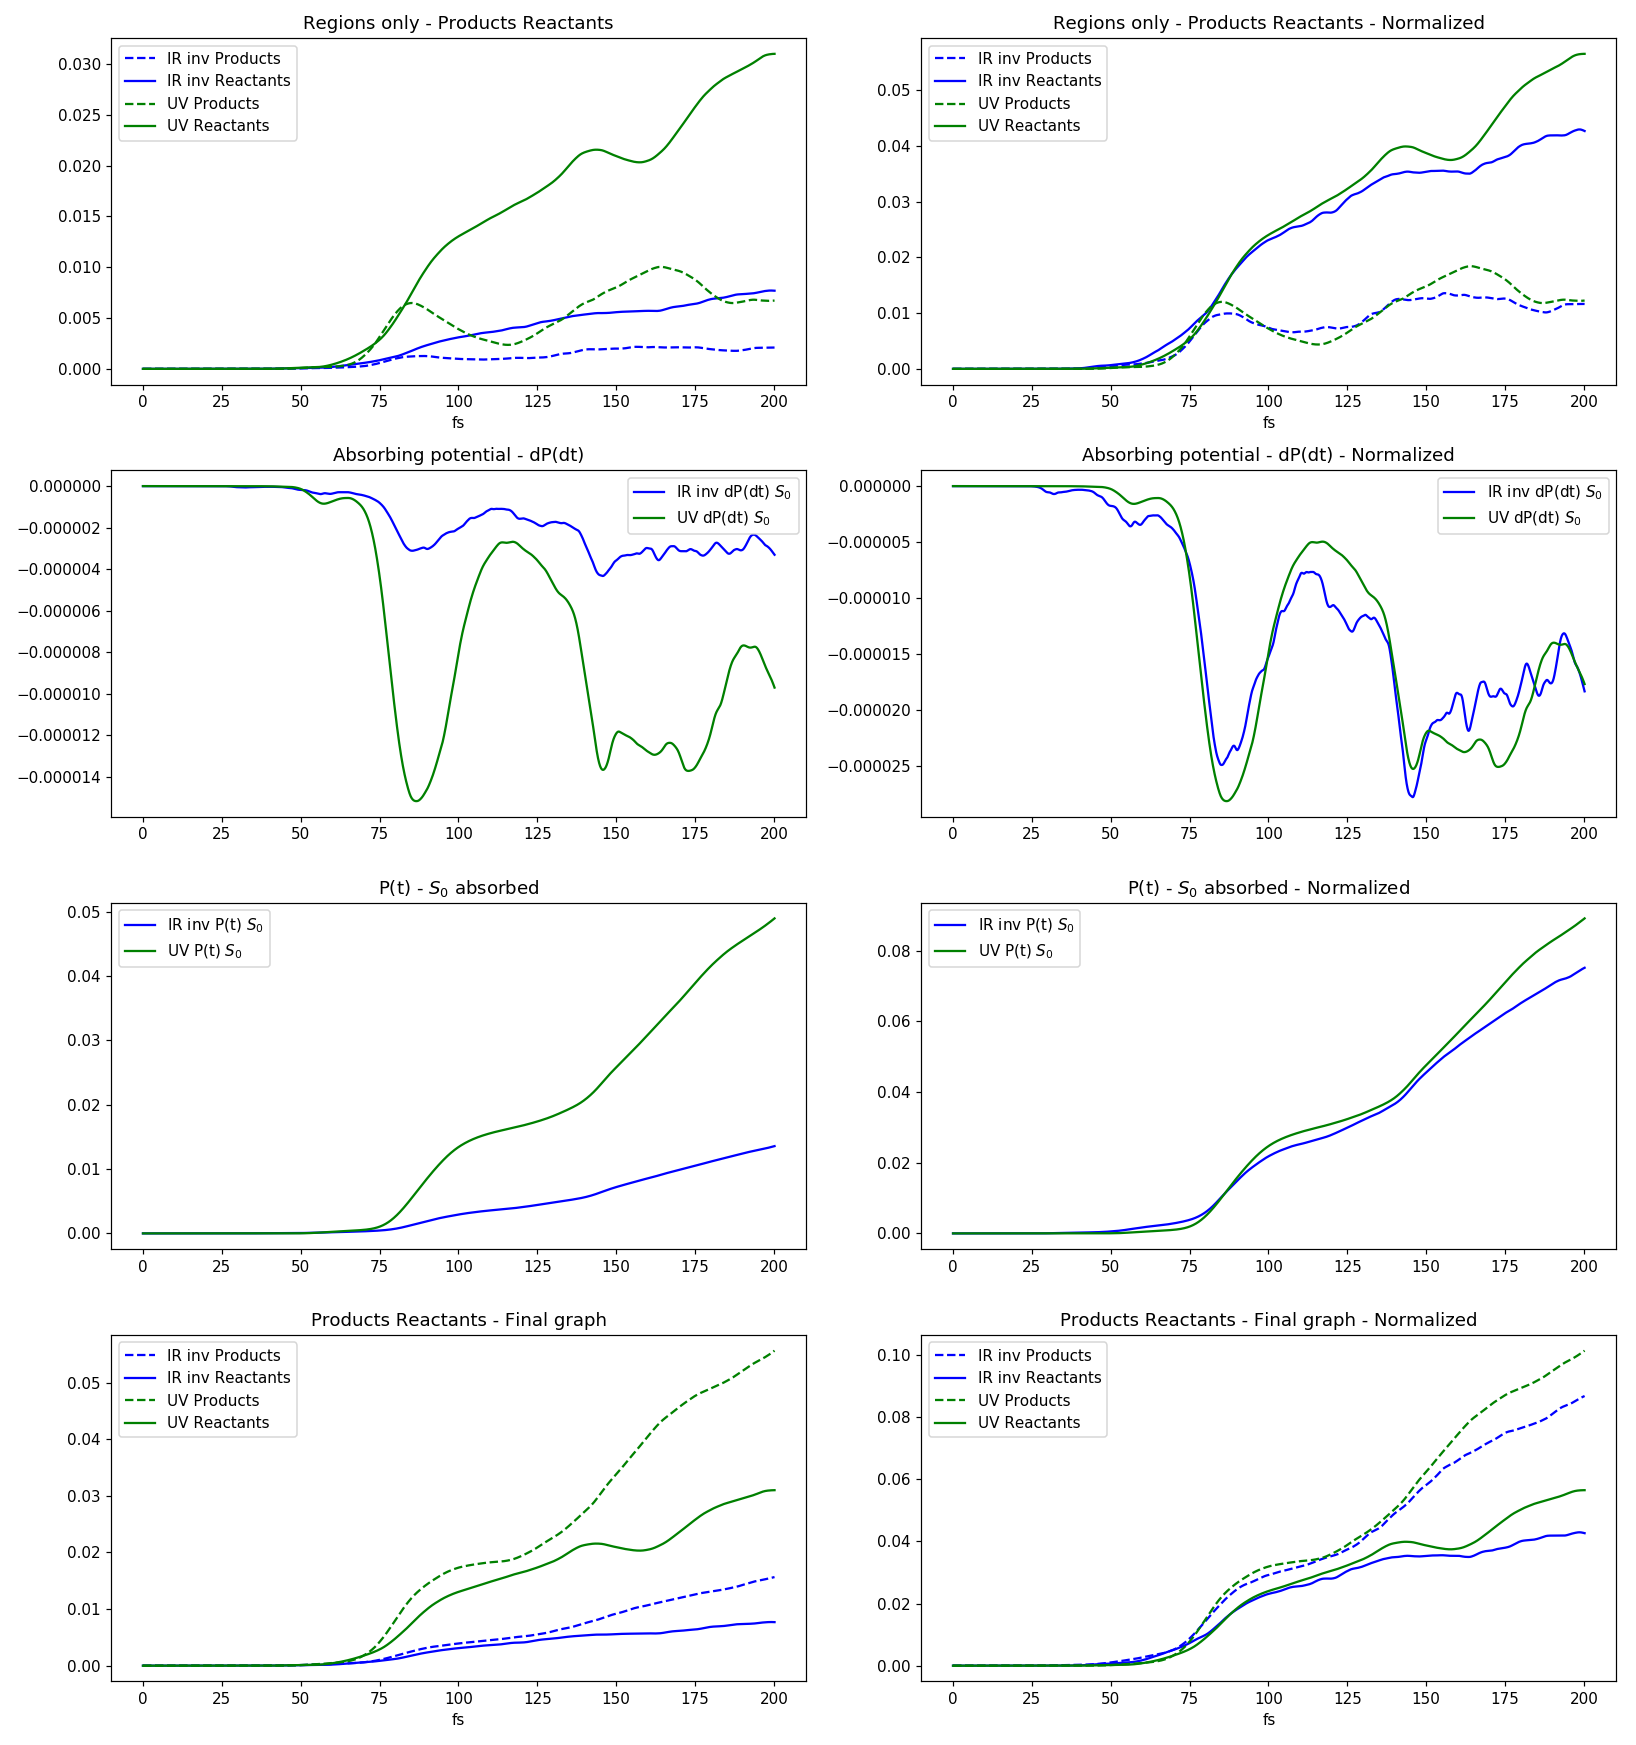

In [15]:
fig, [[ax0, ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]] = plt.subplots(4,2,figsize=(15,16))

labelz = ['IR inv','UV']
runs = [e,b]

for ind,i in enumerate(runs):
    ax0.plot(i['fs'].iloc[:,1],  i['Products']      , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax0.plot(i['fs'].iloc[:,1],  i['Reactants']     , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax0.plot(i['fs'].iloc[:,1],  i['FC after pulse'], label='{} FC'.format(labelz[ind])       , ls=':', lw=0.5,  color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Products'] /i['Norm_factor (t)']     , label='{} Products'.format(labelz[ind]) , ls='--', color=colors[ind])
    ax1.plot(i['fs'].iloc[:,1],  i['Reactants']/i['Norm_factor (t)']     , label='{} Reactants'.format(labelz[ind]),          color=colors[ind])
    #ax1.plot(i['fs'].iloc[:,1],  i['FC after pulse']/i['Norm_factor (t)'], label='{} FC'.format(labelz[ind])       , lw=0.5, ls=':',  color=colors[ind])

ax0.set_xlabel('fs')
ax0.set_title('Regions only - Products Reactants')
ax0.legend()
ax1.set_xlabel('fs')
ax1.set_title('Regions only - Products Reactants - Normalized')
ax1.legend()

for ind,i in enumerate(runs):
    ax2.plot(i['fs'].iloc[:,1],     i['Abs S0'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax3.plot(i['fs'].iloc[:,1],     i['Abs S0']/i['Norm_factor (t)'], label=r'{} dP(dt) $S_0$'.format(labelz[ind]), color=colors[ind])

ax2.set_title('Absorbing potential - dP(dt)')
ax2.legend()
ax3.set_title('Absorbing potential - dP(dt) - Normalized')
ax3.legend()


for ind,i in enumerate(runs):
    ax4.plot(i['fs'].iloc[:,1],     i['P(t) S0'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    ax5.plot(i['fs'].iloc[:,1],     i['P(t) S0']/i['Norm_factor (t)'], label=r'{} P(t) $S_0$'.format(labelz[ind]), color=colors[ind])
    
ax4.set_title(r'P(t) - $S_0$ absorbed')
ax4.legend()
ax5.set_title(r'P(t) - $S_0$ absorbed - Normalized')
ax5.legend()

for ind,i in enumerate(runs):
    ax6.plot(i['fs'].iloc[:,1],     i['Products_F'] ,   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax6.plot(i['fs'].iloc[:,1],     i['Reactants_F'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Products_F'] /i['Norm_factor (t)'],   label='{} Products'.format(labelz[ind]),  ls='--', color=colors[ind])
    ax7.plot(i['fs'].iloc[:,1],     i['Reactants_F']/i['Norm_factor (t)'],   label='{} Reactants'.format(labelz[ind]), color=colors[ind])

ax6.set_xlabel('fs')
ax6.set_title('Products Reactants - Final graph')
ax6.legend()
ax7.set_xlabel('fs')
ax7.set_title('Products Reactants - Final graph - Normalized')
ax7.legend()

fig.tight_layout();